## Organizing the Science News Dataset

In [1]:
from imports import *
np.random.seed(20140101)

The Science News dataset consists of a $1153 \times 1047$ matrix, representing the abstracts of a set of documents published in Science News. The columns of the matrix are 1047 documents on a variety of topics. The rows of the matrix are each a word that appears in one or more of the documents, and the data in each column of the matrix represents an empirical probability distribution on the words for a particular document. We would like to organize the documents and words jointly using the questionnaire algorithm; the intuition is that the words belong to related categories or topics, such that the EMD defined on those words will help to organize the documents. Further, some words are substitutable for each other; one author might prefer to use one synonym while another prefers a different one. If we can group such words into folders, we will find affinities between documents that might not be available naively.

The words are preprocessed to remove common words like "the", etc, and words which appear in only one document, such as names. However, as we will detect, there are still quite a number of words which remain which are not terribly meaningful. Further, we will purposefully partially cripple the dataset by ignoring the probability distribution information and simply replacing any positive probability with a +1, while leaving zeros alone. Hence we will change the data into binary questionnaire type, but we will still be able to first of all detect outlier words/documents and then organize the documents such that in the embedding we will see reasonable structure among externally validated document types. 

In [2]:
%run py_load_data.py sn
binary_data = np.ones(data.shape)*(data > 0.0)
m,n = data.shape
def remove_data(indices,direction):
    global data, binary_data
    if direction == "words":
        global words
        keep_indices = [x for x in xrange(m) if x not in indices]
        data = data[keep_indices,:]
        words = words[keep_indices]
        print "removed {} words".format(len(indices))
    elif direction == "docs":
        keep_indices = [x for x in xrange(n) if x not in indices]
        global doc_titles, doc_class
        data = data[:,keep_indices]
        doc_titles = doc_titles[keep_indices]
        doc_class = doc_class[keep_indices]
        print "removed {} docs".format(len(indices))
    binary_data = np.ones(data.shape)*(data > 0.0)

### Outlier Detection

We begin by calculating an initial affinity on the rows using two methods: cosine similarity and a Gaussian kernel on the Euclidean distance between rows. We see that the Gaussian kernel organizes the data into a slightly nicer curve. Both embeddings, however, have points that are seemingly outliers. We will investigate this in a moment.

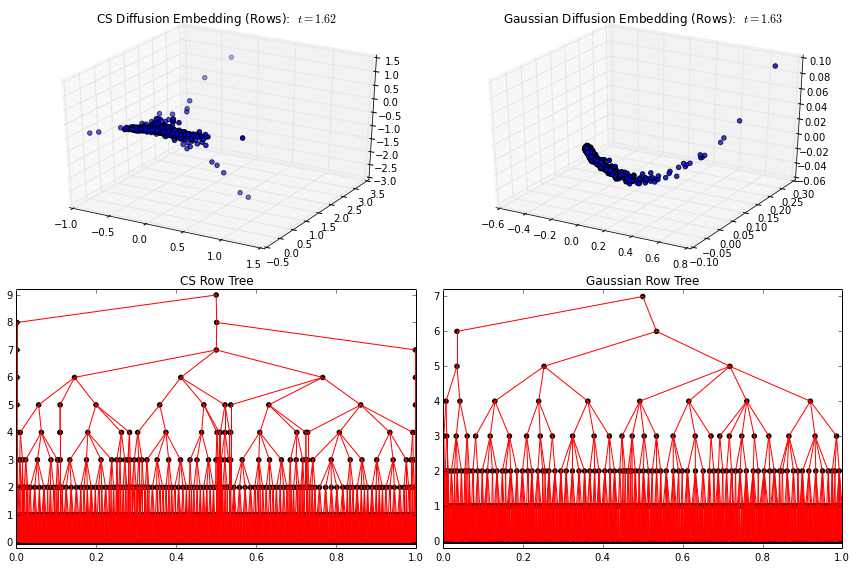

In [3]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221,projection="3d")
cs_row_aff = affinity.mutual_cosine_similarity(binary_data.T)
cs_vecs, cs_vals = markov.markov_eigs(cs_row_aff,4)
plot_embedding(cs_vecs,cs_vals,ax=ax1,
               title="CS Diffusion Embedding (Rows): ")
ax2 = fig.add_subplot(222,projection="3d")
g_row_aff = affinity.gaussian_euclidean(binary_data.T,knn=10)
g_vecs, g_vals = markov.markov_eigs(g_row_aff,4)
plot_embedding(g_vecs,g_vals,ax=ax2,
               title="Gaussian Diffusion Embedding (Rows): ")
fig.add_subplot(223)
cs_row_tree = flex_tree_build.flex_tree_diffusion(cs_row_aff,1.0)
plot_tree(cs_row_tree,title="CS Row Tree")
fig.add_subplot(224)
g_row_tree = flex_tree_build.flex_tree_diffusion(g_row_aff,1.0)
plot_tree(g_row_tree,title="Gaussian Row Tree")
plt.tight_layout()
plt.show()

We do the same thing for the columns. Notice that both of the column embeddings have a single outlier which is quite far away from the main body of points.

In [4]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221,projection="3d")
cs_col_aff = affinity.mutual_cosine_similarity(binary_data)
cs_vecs, cs_vals = markov.markov_eigs(cs_col_aff,4)
plot_embedding(cs_vecs,cs_vals,ax=ax1,
               title="CS Diffusion Embedding (Cols): ")
ax2 = fig.add_subplot(222,projection="3d")
g_col_aff = affinity.gaussian_euclidean(binary_data,knn=10)
g_vecs, g_vals = markov.markov_eigs(g_col_aff,4)
plot_embedding(g_vecs,g_vals,ax=ax2,
               title="Gaussian Diffusion Embedding (Cols): ")
fig.add_subplot(223)
cs_col_tree = flex_tree_build.flex_tree_diffusion(cs_col_aff,1.0)
plot_tree(cs_col_tree,title="CS Col Tree")
fig.add_subplot(224)
g_col_tree = flex_tree_build.flex_tree_diffusion(g_col_aff,1.0)
plot_tree(g_col_tree,title="Gaussian Col Tree")
plt.tight_layout()
plt.show()

The title of the outlier document is "Science News of the Year 2001 Compiled."  It's not that surprising that such a document would be an outlier in our dataset, as it is likely to contain a wide variety of words from all different disciplines, and so be unlike any other document. We will remove this document from the dataset to facilitate a cleaner analysis.

In [5]:
print np.array([x.size for x in g_col_tree.children])
print doc_titles[g_col_tree.children[0].elements]

[   1 1046]
[u'10393. :  , Dec. 22, 2001 > Science News of the Year 2001 Compiled']


We can repeat this analysis on the row trees, and identify the words which are outliers to the main group of words.

In [6]:
print np.array([x.size for x in g_row_tree.children])
print ",".join(words[g_row_tree.children[0].elements])

[  80 1073]
year,university,study,scientist,people,cell,time,team,science,group,system,animal,percent,work,found,note,human,state,data,million,sn,week,effect,world,test,problem,colleague,during,finding,body,life,suggest,form,number,month,evidence,ago,result,using,type,national,day,change,different,known,produce,part,cause,case,laboratory,find,point,center,early,remain,re,down,don,california,around,without,get,similar,provide,institute,past,nature,help,amount,too,need,look,little,example,think,although,add,recent,explain,come


These words are quite vague in meaning and not very discriminative of different documents from each other. Most are likely to be found in almost any document, such as "university" or "science". Words like "california" may not appear in many documents, but will be unhelpful in distinguishing the meanings of various documents. So we will remove these words from the dataset as well.

In [7]:
remove_data(g_row_tree.children[0].elements,"words")
remove_data(g_col_tree.children[0].elements,"docs")
print binary_data.shape

removed 80 words
removed 1 docs
(1073L, 1046L)


### Organization

Now let us run the questionnaire process on the remaining data.

In [8]:
kwargs = {}
kwargs["threshold"] = 0.0
kwargs["row_alpha"] = 0.0
kwargs["col_alpha"] = 0.0
kwargs["row_beta"] = 1.0
kwargs["col_beta"] = 1.0
kwargs["tree_constant"] = 1.0
kwargs["n_iters"] = 3
params = questionnaire.PyQuestParams(questionnaire.INIT_AFF_GAUSSIAN,
                                     questionnaire.TREE_TYPE_FLEXIBLE,
                                     questionnaire.DUAL_EMD,
                                     questionnaire.DUAL_EMD,**kwargs)

In [9]:
qrun = questionnaire.pyquest(binary_data,params)
row_tree = qrun.row_trees[-1]
col_tree = qrun.col_trees[-1]
row_emd = dual_affinity.calc_emd(binary_data.T,col_tree,
                                 params.row_alpha,params.row_beta)
col_emd = dual_affinity.calc_emd(binary_data,row_tree,
                                 params.col_alpha,params.col_beta)
row_aff = dual_affinity.emd_dual_aff(row_emd)
col_aff = dual_affinity.emd_dual_aff(col_emd)
row_vecs,row_vals = markov.markov_eigs(row_aff,12)
col_vecs,col_vals = markov.markov_eigs(col_aff,12)

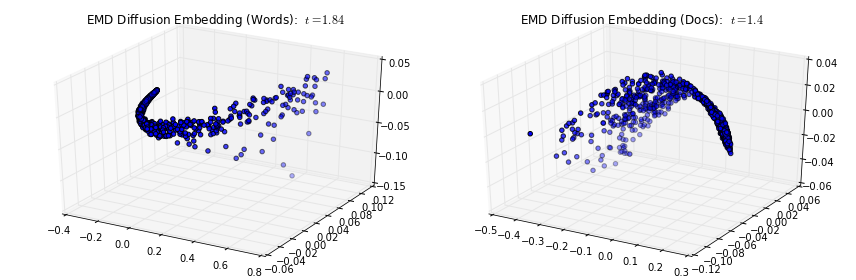

In [10]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121,projection="3d")
plot_embedding(row_vecs,row_vals,ax=ax1,
                          title="EMD Diffusion Embedding (Words): ")
ax2 = fig.add_subplot(122,projection="3d")
plot_embedding(col_vecs,col_vals,ax=ax2,
                          title="EMD Diffusion Embedding (Docs): ")
plt.tight_layout()
plt.show()

Compared to embeddings based on the raw intial affinities we obtained earlier, the EMD iterated embeddings are much smoother and "nicer" looking. 

The following code will open an external application which will allow the user to browse groups of words or documents, a process hard to simulate on the page but useful for subjectively evaluating the quality of word or document folders. 

In [11]:
#viewer_files.write_tree_viewer("words.vw",row_tree,row_vecs,row_vals,words)
#viewer_files.write_tree_viewer("docs.vw",col_tree,col_vecs,col_vals,doc_titles)
#%run tree_viewer2.py words.vw
#%run tree_viewer2.py docs.vw

We can also color the nodes of the diffusion embedding with eight categories of document supplied externally. Because the classification of document types is somewhat inherently murky and we weren't working to predict this variable, the eight categories, while very loosely running in stripes along the embedding, aren't really cleanly organized.

In [12]:
COLORS = "mgkybrcw"
nodecolors = [COLORS[x-1] for x in doc_class]
for x,y in zip(COLORS,score_titles):
    print x,y

m Anth
g Space
k Behav
y Env
b Life
r MathCS
c Med
w PhysTech


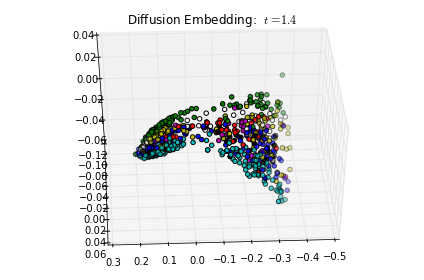

In [13]:
plot_embedding(col_vecs,col_vals,nodecolors=nodecolors,azim=87,elev=43)
plt.tight_layout()
plt.show()

However, if we combine the eight categories into three larger categories: (Space,MathCS,PhysTech), (Anth,Behav,Env), and (Life,Med), and paint the embedding in that way, we can see that the larger categories (which probably overlap each other significantly in reality) are painted in recognizable stripes across the embedding.

In [14]:
COLORS = "rbrrcbcb"
nodecolors = [COLORS[x-1] for x in doc_class]
for x,y in zip(COLORS,score_titles):
    print x,y

r Anth
b Space
r Behav
r Env
c Life
b MathCS
c Med
b PhysTech


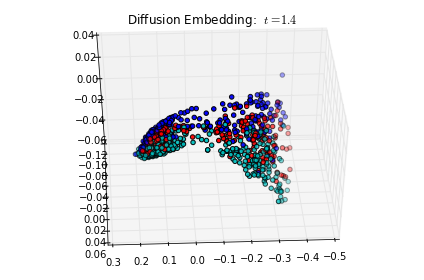

In [15]:
plot_embedding(col_vecs,col_vals,nodecolors=nodecolors,azim=87,elev=43)
plt.tight_layout()
plt.show()

We can additionally look at embeddings that are the result of different parameters. For example, suppose that we let $\beta$ on the columns be -1 instead of 1. Then we are putting a lot more weight in EMD on individual words and smaller groups of words. The resulting embedding is a lot less smooth, but the category painting reveals some of the same structure in a different shape:

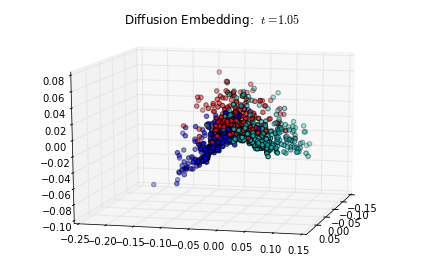

In [16]:
params.col_beta = -1.0
qrun = questionnaire.pyquest(binary_data,params)
row_tree = qrun.row_trees[-1]
col_tree = qrun.col_trees[-1]
row_emd = dual_affinity.calc_emd(binary_data.T,col_tree,
                                 params.row_alpha,params.row_beta)
col_emd = dual_affinity.calc_emd(binary_data,row_tree,
                                 params.col_alpha,params.col_beta)
row_aff = dual_affinity.emd_dual_aff(row_emd)
col_aff = dual_affinity.emd_dual_aff(col_emd)
row_vecs,row_vals = markov.markov_eigs(row_aff,12)
col_vecs,col_vals = markov.markov_eigs(col_aff,12)
plot_embedding(col_vecs,col_vals,nodecolors=nodecolors,
                          azim=14,elev=13)
plt.tight_layout()
plt.show()